# Convert the Google Scanned Objects Dataset to Kubric

Google recently released 1033 scanned objects under a CC-by 4.0 license:
https://app.ignitionrobotics.org/GoogleResearch/fuel/collections/Google%20Scanned%20Objects

This Notebook downloads all those models and converts them into a format that Kubric can use.

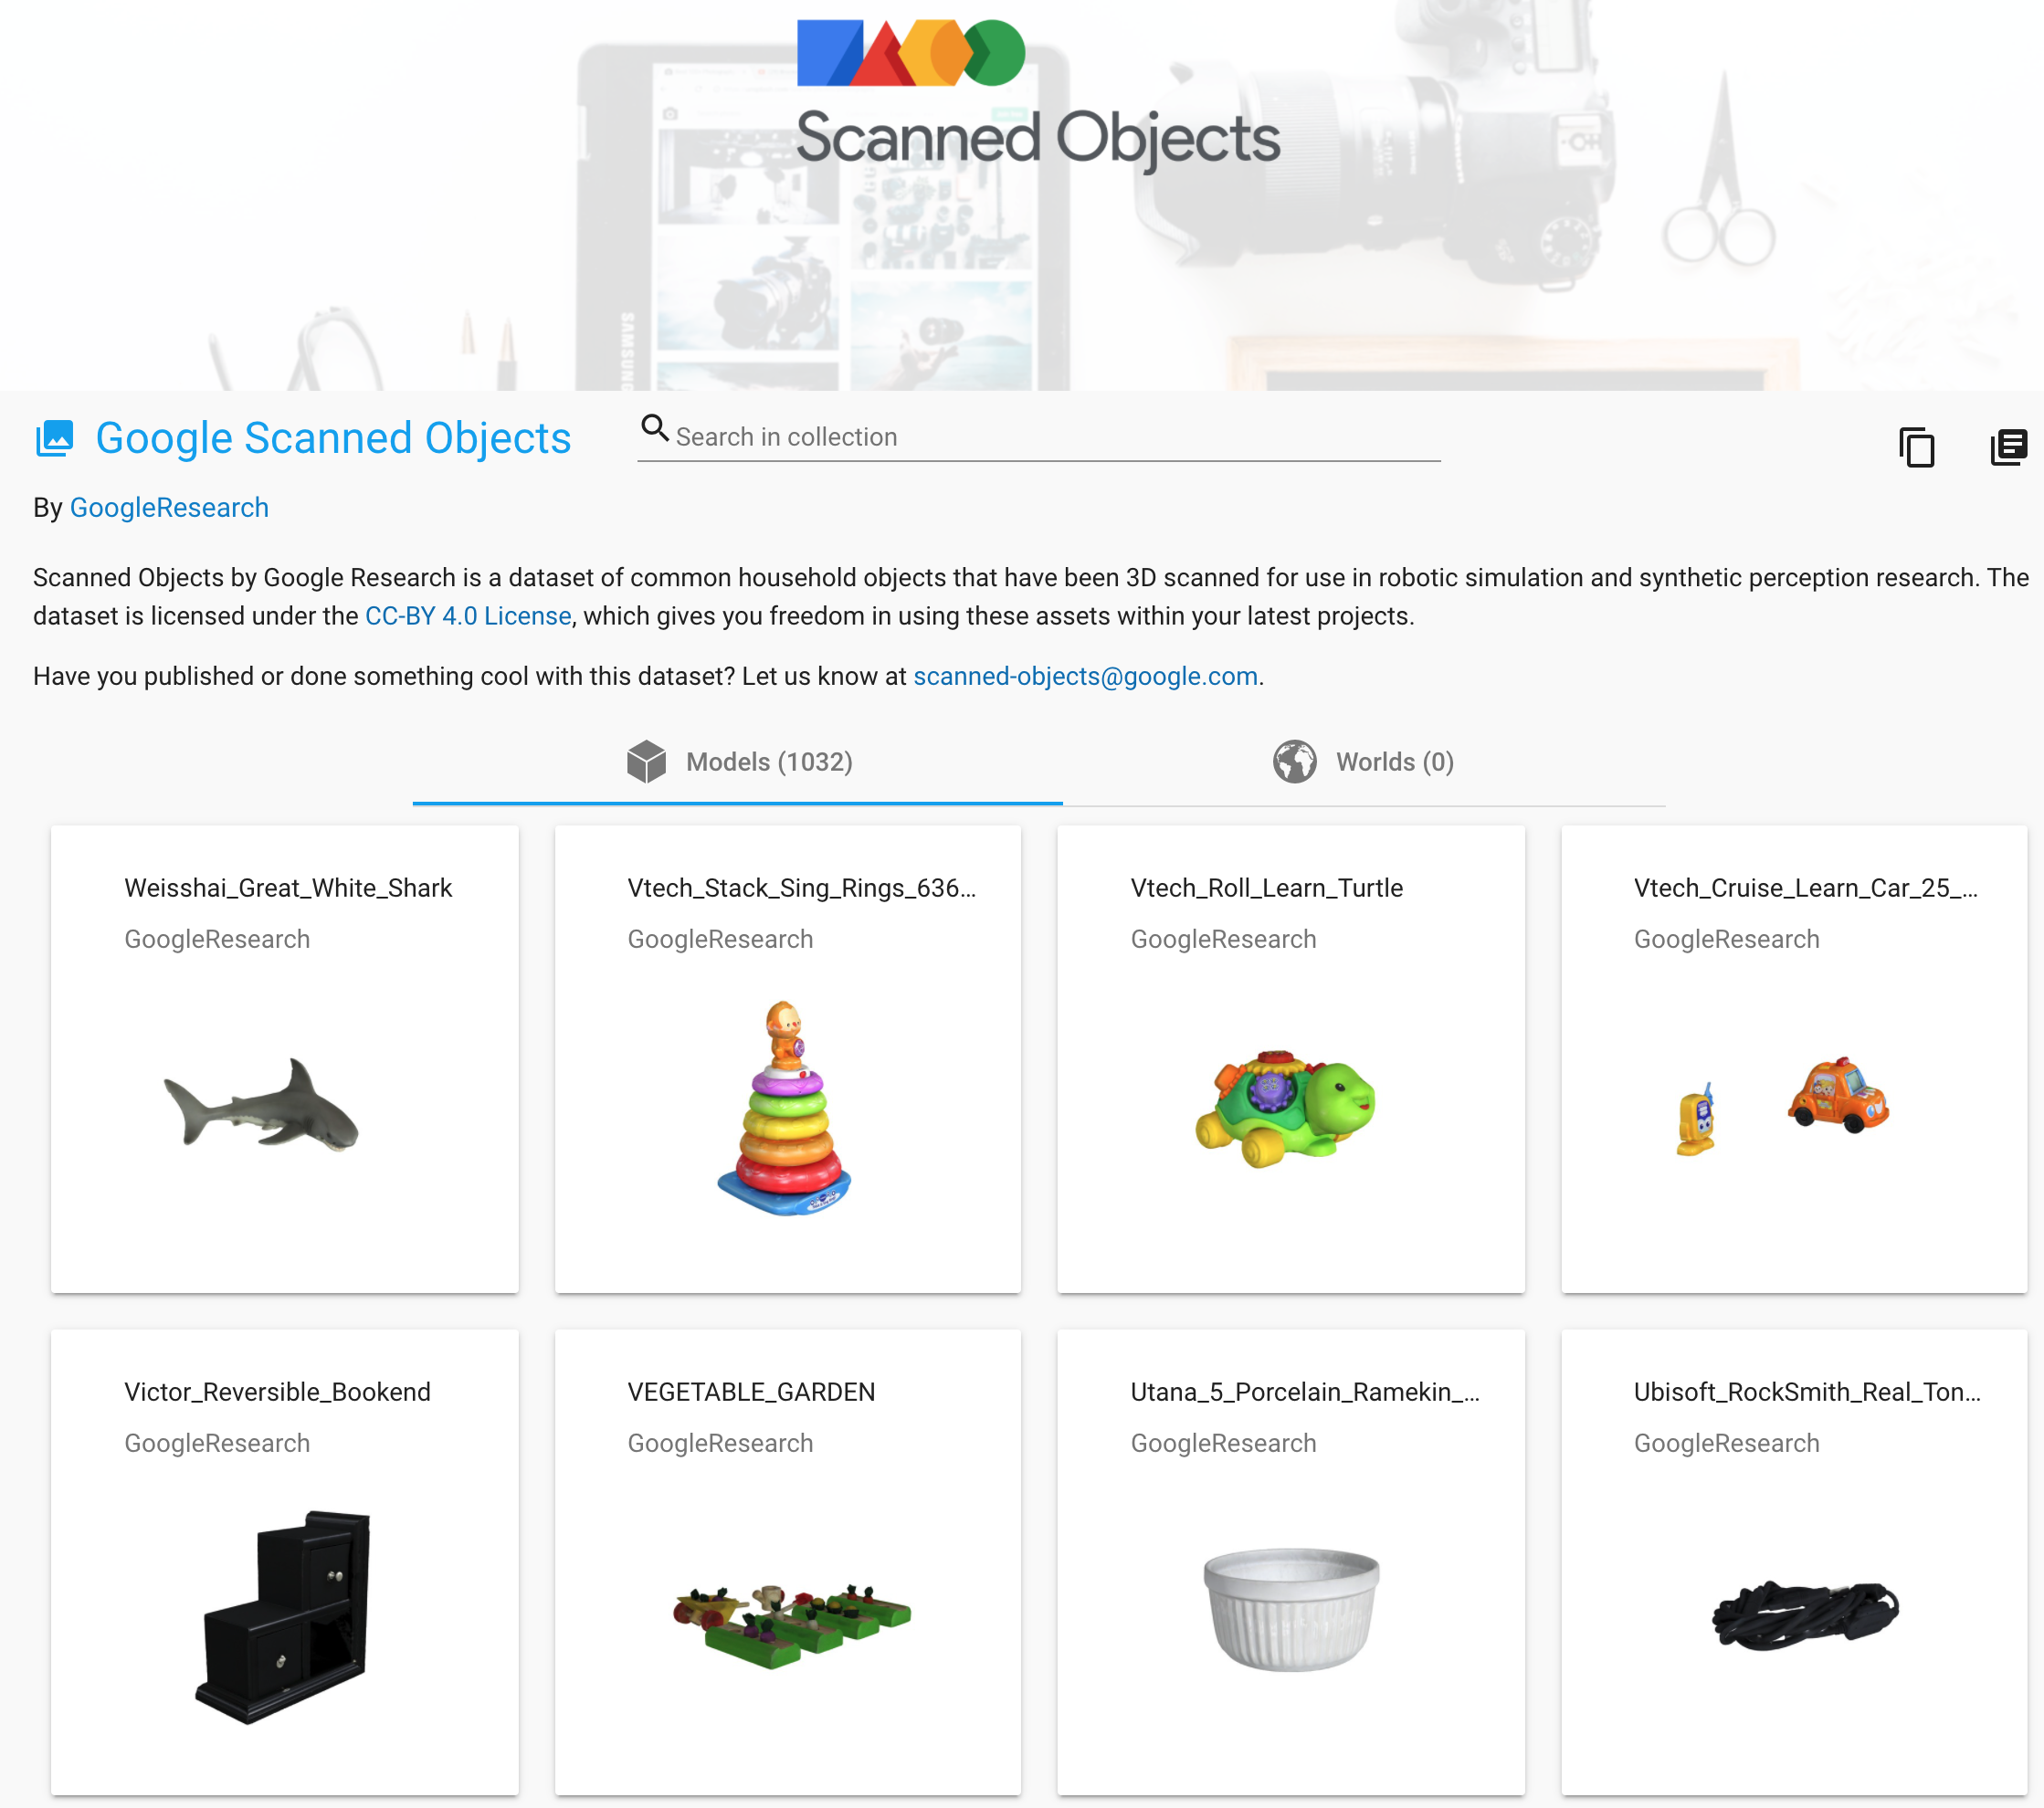

In [13]:
import json
import numpy as np
import os
import pybullet as pb
import re
import shutil
import ssl
import tarfile
import trimesh as tm
import trimesh.exchange.obj as tri_obj
import urllib.request
import zipfile

from pathlib import Path

# Configure Target Directories

In [ ]:
download_dir = Path('./GSO')
target_dir = Path("../Assets/GSO")

## Download Assets

In [39]:
# make sure download dir exists
download_dir.mkdir(parents=True, exist_ok=True)


# bypass SSL verification
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

# Get a list of available assets
list_of_assets = []
page = 1
while True:
    try:
        with urllib.request.urlopen('https://fuel.ignitionrobotics.org/1.0/GoogleResearch/models?page={}'.format(page)) as f:
            list_of_assets.extend(json.load(f))
    except urllib.error.HTTPError:
        break
    page += 1

# download 
for i, asset in enumerate(list_of_assets):
    name = asset['name']
    url = "https://fuel.ignitionrobotics.org/1.0/GoogleResearch/models/{name}/1/{name}.zip".format(name=urllib.request.quote(name))
    filename = download_dir / f"{name}.zip"
    if not filename.exists():
        try:
            print(f"{i+1:4d}/{len(list_of_assets)}: Fetching '{name}' from {url} into {filename}")
            urllib.request.urlretrieve(url, filename)
        except (urllib.error.HTTPError, urllib.error.URLError) as e:
            print("FAILED! skipping", e)
            

 601/1033: Fetching 'Pokémon_Yellow_Special_Pikachu_Edition_Nintendo_Game_Boy_Color' from https://fuel.ignitionrobotics.org/1.0/GoogleResearch/models/Pok%C3%A9mon_Yellow_Special_Pikachu_Edition_Nintendo_Game_Boy_Color/1/Pok%C3%A9mon_Yellow_Special_Pikachu_Edition_Nintendo_Game_Boy_Color.zip into GSO/Pokémon_Yellow_Special_Pikachu_Edition_Nintendo_Game_Boy_Color.zip
 602/1033: Fetching 'Pokémon_Omega_Ruby_Alpha_Sapphire_Dual_Pack_Nintendo_3DS' from https://fuel.ignitionrobotics.org/1.0/GoogleResearch/models/Pok%C3%A9mon_Omega_Ruby_Alpha_Sapphire_Dual_Pack_Nintendo_3DS/1/Pok%C3%A9mon_Omega_Ruby_Alpha_Sapphire_Dual_Pack_Nintendo_3DS.zip into GSO/Pokémon_Omega_Ruby_Alpha_Sapphire_Dual_Pack_Nintendo_3DS.zip


# Conversion

In [41]:
# define functions

URDF_TEMPLATE = """
<robot name="{id}">
    <link name="base">
        <contact>
            <lateral_friction value="{friction}" />  
        </contact>
        <inertial>
            <origin xyz="{center_mass[0]} {center_mass[1]} {center_mass[2]}" />
            <mass value="{mass}" />
            <inertia ixx="{inertia[0][0]}" ixy="{inertia[0][1]}" 
                     ixz="{inertia[0][2]}" iyy="{inertia[1][1]}" 
                     iyz="{inertia[1][2]}" izz="{inertia[2][2]}" />
        </inertial>
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <mesh filename="visual_geometry.obj" />
            </geometry>
        </visual>
        <collision>
            <origin xyz="0 0 0" />
            <geometry>
                <mesh filename="collision_geometry.obj" />
            </geometry>
        </collision>
    </link>
</robot>
"""

def get_object_properties(tmesh, name, density=None, friction=None):
    if density is None:
        tmesh.density = 1000.0
    friction = 0.0

    rounda = lambda x: np.round(x, decimals=6).tolist()
    roundf = lambda x: float(np.round(x, decimals=6))

    properties = {
      "id": name,
      "density": roundf(tmesh.density),
      "friction": roundf(friction),
      "nr_vertices": len(tmesh.vertices),
      "nr_faces": len(tmesh.faces),
      "bounds": rounda(tmesh.bounds),
      "area": roundf(tmesh.area),
      "volume": roundf(tmesh.volume),
      "mass": roundf(tmesh.mass),
      "center_mass": rounda(tmesh.center_mass),
      "inertia": rounda(tmesh.moment_inertia),
      "is_convex": tmesh.is_convex,
      "euler_number": tmesh.euler_number,  # used for topological analysis (see: http://max-limper.de/publications/Euler/index.html),
    }
    return properties

def convert_google_scanned_object(path, target_dir):
    name = path.stem
    asset_dir = path.parent / name
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(asset_dir)
    texture_path = asset_dir / 'materials' / 'textures' / 'texture.png'
    obj_path = asset_dir / 'meshes' / 'model.obj'
    mat_path = asset_dir / 'meshes' / 'model.mtl'

    target_asset_dir = target_dir / name
    if target_asset_dir.exists():
        shutil.rmtree(target_asset_dir)
    target_asset_dir.mkdir(parents=True, exist_ok=True)

    vis_path = target_asset_dir / 'visual_geometry.obj'
    coll_path = target_asset_dir / 'collision_geometry.obj'
    urdf_path = target_asset_dir / 'object.urdf'
    json_path = target_asset_dir / "data.json"
    tex_path = target_asset_dir / 'texture.png'
    tar_path = target_dir / (name + ".tar.gz")

    shutil.copy(texture_path, asset_dir / 'meshes' / 'texture.png')
    # import mesh into trimesh
    tmesh = tm.load_mesh(obj_path, file_type='obj')
    # center it around center of mass
    tmesh.apply_translation(-tmesh.center_mass)
    # export to obj again
    obj_content = tri_obj.export_obj(tmesh)
    obj_content = re.sub('mtllib material0.mtl\nusemtl material0\n', 'mtllib visual_geometry.mtl\nusemtl material_0\n', obj_content)
    with open(vis_path, 'w') as f:
        f.write(obj_content)

    # compute a collision mesh using pybullets VHACD
    pb.vhacd(str(vis_path), 
             str(coll_path), 
             str(target_asset_dir / 'pybullet_logs.txt'))

    # move material and texture
    shutil.move(mat_path, target_asset_dir / 'visual_geometry.mtl')
    shutil.move(texture_path, tex_path)

    properties = get_object_properties(tmesh, name)

    with open(urdf_path, 'w') as f:
        f.write(URDF_TEMPLATE.format(**properties))

    properties["paths"] = {
            "visual_geometry": [str(vis_path)],
            "collision_geometry": [str(coll_path)],
            "urdf": [str(urdf_path)],
            "texture": [str(tex_path)],
        }

    with open(json_path, "w") as f:
        json.dump(properties, f, indent=4, sort_keys=True)


    print("          saving as", tar_path)
    with tarfile.open(tar_path, "w:gz") as tar:
        tar.add(target_asset_dir, arcname=name)

    shutil.rmtree(asset_dir)
    shutil.rmtree(target_asset_dir)
    return properties

In [44]:
# make sure target dir exists
target_dir.mkdir(parents=True, exist_ok=True)

# convert invididual assets
details_list = []
list_of_asset_files = sorted(download_dir.glob('*.zip'))
for i, path in enumerate(list_of_asset_files):
    print(f"{i:4d}/{len(list_of_asset_files)}: Converting {path}...")
    properties = convert_google_scanned_object(path, target_dir)
    details_list.append(properties)

with open(target_dir / 'details_list.json', 'w') as f:
    json.dump(details_list, f, indent=4, sort_keys=True)

Zipping into ../Assets/GSO/Reebok_R_CROSSFIT_OLY_UFORM.tar.gz
Zipping into ../Assets/GSO/DPC_Handmade_Hat_Brown.tar.gz
Zipping into ../Assets/GSO/Down_To_Earth_Orchid_Pot_Ceramic_Lime.tar.gz
Zipping into ../Assets/GSO/Melissa_Doug_Shape_Sorting_Clock.tar.gz
Zipping into ../Assets/GSO/PHEEHAN_RUN.tar.gz
Zipping into ../Assets/GSO/Reebok_DMX_MAX_PLUS_RAINWALKER.tar.gz
Zipping into ../Assets/GSO/SAMe_200_KX7ZmOw47co.tar.gz
Zipping into ../Assets/GSO/BATHROOM_CLASSIC.tar.gz
Zipping into ../Assets/GSO/Mastic_Gum.tar.gz
Zipping into ../Assets/GSO/Reebok_TURBO_RC.tar.gz
Zipping into ../Assets/GSO/NattoMax.tar.gz
Zipping into ../Assets/GSO/Pepsi_Cola_Caffeine_Free_12_12_fl_oz_355_ml_cans_144_fl_oz_426_lt.tar.gz
Zipping into ../Assets/GSO/ASICS_GELBlur33_20_GS_Flash_YellowHot_PunchSilver.tar.gz
Zipping into ../Assets/GSO/Rubbermaid_Large_Drainer.tar.gz
Zipping into ../Assets/GSO/JarroSil_Activated_Silicon.tar.gz
Zipping into ../Assets/GSO/Netgear_N750_Wireless_Dual_Band_Gigabit_Router.tar.gz
Zi

# Cleanup

In [ ]:
# delete downloaded assets (only keep the converted ones)
shutil.rmtree(download_dir)


In [46]:
#target_dir = Path("/Users/klausg/Kubric/GoogleScannedObjects/Assets")
properties = []
for path in target_dir.glob('*.tar.gz'):
    name = path.name[:-7] 
    with tarfile.open(path, "r:gz") as tar:
        tar.extract(name + '/data.json', path =target_dir/ 'tmp')
    with open(target_dir / 'tmp' / name / 'data.json', 'r') as f:
        properties.append(json.load(f))
shutil.rmtree(target_dir / 'tmp')
with open(target_dir / 'details_list.json', 'w') as f:
    json.dump(properties, f, indent=4, sort_keys=True)